In [1]:
import math
import os.path
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import random
import statsmodels.api as sm
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_excel("data.xlsx")
data.head()

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,...,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Henry Cejudo,Marlon Moraes,Marc Goddard,2019,"Chicago, Illinois, USA",Red,True,Bantamweight,5,0,...,2,0,0,8,Orthodox,162.56,162.56,135.0,31.0,32.0
1,Valentina Shevchenko,Jessica Eye,Robert Madrigal,2019,"Chicago, Illinois, USA",Red,True,Women's Flyweight,5,0,...,0,2,0,5,Southpaw,165.10,167.64,125.0,32.0,31.0
2,Tony Ferguson,Donald Cerrone,Dan Miragliotta,2019,"Chicago, Illinois, USA",Red,False,Lightweight,3,0,...,3,6,1,14,Orthodox,180.34,193.04,155.0,36.0,35.0
3,Jimmie Rivera,Petr Yan,Kevin MacDonald,2019,"Chicago, Illinois, USA",Blue,False,Bantamweight,3,0,...,1,0,0,6,Orthodox,162.56,172.72,135.0,26.0,29.0
4,Tai Tuivasa,Blagoy Ivanov,Dan Miragliotta,2019,"Chicago, Illinois, USA",Blue,False,Heavyweight,3,0,...,2,0,0,3,Southpaw,187.96,190.50,264.0,32.0,26.0


### Apenas a categoria Peso-Pesados ('Heavyweights')

   O nosso dataframe consiste em uma coleção de dados de todas as lutas da história do UFC, desde 1993 até 2019, contando com profundas informações dos lutadores do evento, como o histórico do lutador, resultados das últimas lutas, idade e até dados de cada embate, por exemplo de quantos golpes foram desferidos na cabeça do adversário naquele específico combate.
   
   Após o dataframe ser lido e exibido pela biblioteca do Pandas, nós nos deparamos com uma tabela que separa as lutas pelas cores dos lados do ringue, sendo o "R_fighter" o lutador do lado vermelho e o "B_fighter" o oponente do lado azul e é assim que se divide as estatísticas das lutas em geral, no caso as informações do lado vermelho começam com o prefixo "R_" e segue o mesmo padrão com o lado azul ("B_").

In [3]:
data.weight_class = data.weight_class.astype('category')
data.Winner = data.Winner.astype('category')

In [4]:
data.Winner.value_counts()

Red     3470
Blue    1591
Draw      83
Name: Winner, dtype: int64

Como o objetivo do projeto é prever de qual lado/cor é o lutador vencedor do combate, fizemos uma contagem do número de vitórias de cada lado.

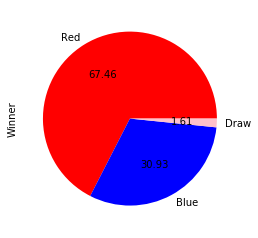

In [5]:
data.Winner.value_counts().plot(kind='pie', colors=['red','blue','pink'], autopct="%0.2f",legend=False);

Após plotar o gráfico da frequência relativa da vitória em seus respectivos lados, pudermos perceber que o lado vermelho acumula 67,46% das vitórias enquanto apenas 30,93% do lado azul, desbancando uma ideia inicial de igualdade entre os lados em relação às vitórias. 

Uma vez sabendo que os lutadores campeões lutam pelo lado vermelho, pensamos que talvez o lado vermelho poderia ter alguma vantagem na porcentagem de vitórias, já que geralmente os campeões são considerados melhores que a maioria de seus oponentes.
Portanto, resolvemos plotar um gráfico a fim de analisar esta vantagem e como esperado, os campeões realmente ganham mais que os desafiantes, cerca de uma proporção 4 para 1.

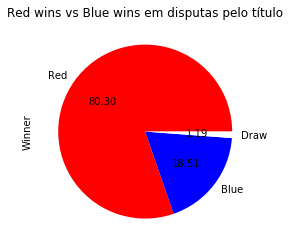

In [6]:
graf_winner_with_title = data.loc[: , ["Winner", "title_bout"]]
graf_winner_with_title1 = graf_winner_with_title.loc[(graf_winner_with_title.title_bout==True),:]
plt.title("Red wins vs Blue wins em disputas pelo título")
graf_winner_with_title1.Winner.value_counts().plot(kind='pie', colors=['red','blue',"white"],autopct="%0.2f",legend=False);

Porém, quantas vezes ocorrem disputas por títulos de modo que possa alterar tão significantemente a porcentagem de vitórias dos lados?
Para isso, plotamos um gráfico da ocorrência relativa das disputas:

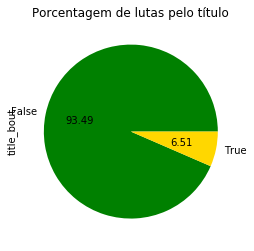

In [8]:
plt.title("Porcentagem de lutas pelo título")
data['title_bout'].value_counts().plot(kind='pie', colors=['green','gold'],autopct="%0.2f",legend=False);

De todas as lutas que ocorreram no UFC, 7% são disputas por títulos, mostrando-se uma quantia pequena mas relativamente relevante em relação ao total.

Agora, para saber se esta vantagem se da apenas pelo fato do lado vermelho ser o campeão, decidimos fazer o mesmo gráfico de  vitórias do Red x vitórias do Blue mas apenas pelas lutas que não disputam o cinturão:

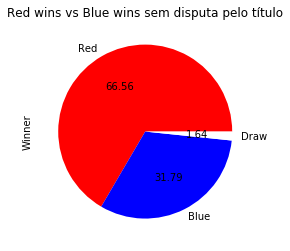

In [9]:
graf_winner_with_title = data.loc[: , ["Winner", "title_bout"]]
graf_winner_with_title1 = graf_winner_with_title.loc[(graf_winner_with_title.title_bout==False),:]
plt.title("Red wins vs Blue wins sem disputa pelo título")
graf_winner_with_title1.Winner.value_counts().plot(kind='pie', colors=['red','blue',"white"],autopct="%0.2f",legend=False);

Como resultado, é possível analisar que mesmo em lutas quais não disputam o título, a vantagem do lado vermelho se mantém. Mas o que explicaria isso?

Após pesquisas, descobrimos que o lado vermelho, na maioria das vezes, é defendido por lutadores "favoritos" das apostas, ou seja, são lutadores apontados como os possíveis vencedores do confronto devido aos seus últimos resultados nos recentes embates e/ou o "status" que o lutador possui.

Mudando de assunto, queriamos saber como é distribuída as categorias de peso no UFC, para futuras análises...

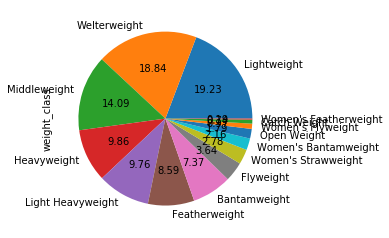

In [7]:
data['weight_class'].value_counts().plot(kind='pie',autopct="%0.2f",legend=False);

Após o plot do gráfico, resolvemos dividir as categorias por gênero:

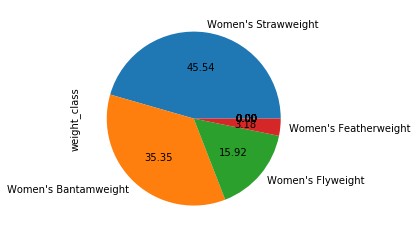

In [43]:
data_mulher = data.loc[(data.weight_class=="Women's Bantamweight")|
                       (data.weight_class=="Women's Featherweight")|
                       (data.weight_class=="Women's Flyweight")|
                       (data.weight_class=="Women's Strawweight"),:]
data_mulher.weight_class.value_counts().plot(kind='pie',autopct="%0.2f",legend=False);

São 4 categorias de peso para as mulheres.

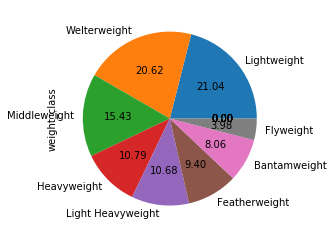

In [10]:
data_homem = data.loc[(data.weight_class=="Flyweight")|
                       (data.weight_class=="Bantamweight")|
                       (data.weight_class=="Featherweight")|
                       (data.weight_class=="Lightweight")|
                       (data.weight_class=="Welterweight")|
                       (data.weight_class=="Middleweight")|
                       (data.weight_class=="Light Heavyweight")|
                       (data.weight_class=="Heavyweight"),:]
#data_homem.weight_class.value_counts().plot(kind='pie',autopct="%0.2f",legend=False);
data_homem.weight_class.value_counts().plot(kind='pie',autopct="%0.2f",legend=False);

São 8 categorias na divisão masculina, distribuídas majoritariamente entre os pesos leves ("Lightweights"), meio-médios ("Welterweight") e médios ("Middleweight"). 

Vamos ver se a superioridade do vermelho sobre o azul prevalece no gênero masculino...

Mas primeiro vamos fazer algumas funções...
A primeira, vamos determinar todos os pesos de qualquer divisão de gênero.
Enquanto na segunda vamos plotar os gráficos de vitórias entre os lados vermelhos e azuis.

In [13]:
def pesos(df_pesos):
    data_homem_pesos = []
    for i in df_pesos:
        if i not in data_homem_pesos:
            data_homem_pesos.append(i)
    return data_homem_pesos

In [41]:
def plota_graficos_por_peso(df):
    v=0
    i=-1
    for p in pesos(df.weight_class):
        v = data_homem.Winner.loc[(df.weight_class==p)]
        v.value_counts().plot(kind='pie',colors=['red','blue',"white"],autopct="%0.2f",legend=False);
        plt.title(p)
        plt.figure(i)
        i+=1
    return None
    

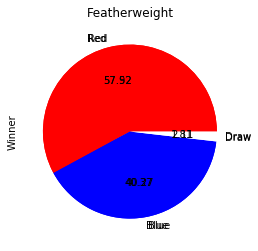

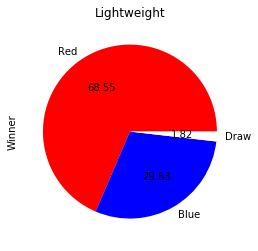

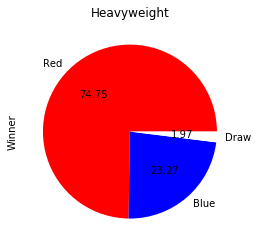

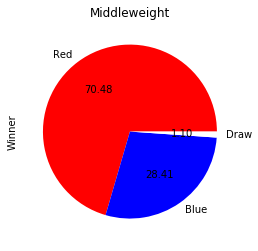

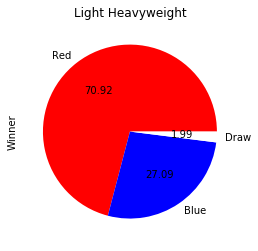

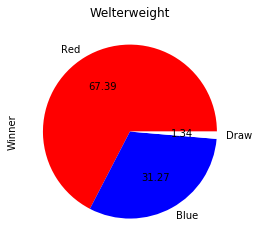

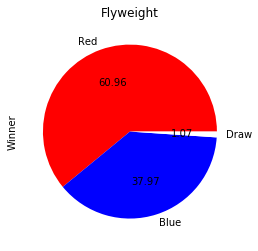

<Figure size 432x288 with 0 Axes>

In [47]:
plota_graficos_por_peso(data_homem)

Após a observação dos gráficos, é possivel concluir que o lado vermelho sempre leva vantagem, em todos os pesos e em alguns mais do que outros...

### Blue = 0
### Red = 1

In [6]:
data_heavy = data.loc[(data.weight_class=='Lightweight'),:]
bool_to_number = {False: 0, True: 1}
string_to_number = {'Blue': 0, 'Red': 1, 'Draw': 2}
data_heavy['title_bout'] = data_heavy['title_bout'].map(bool_to_number)
data_heavy['Winner'] = data_heavy['Winner'].map(string_to_number)

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [7]:
data_heavy.describe()

,date,Winner,title_bout,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,...,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
count,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.0,743.000000,743.000000,743.000000,...,989.000000,989.000000,989.000000,989.000000,989.000000,988.000000,951.000000,988.000000,960.000000,983.000000
mean,2012.344793,0.721941,0.042467,3.080890,0.438827,0.791709,0.0,9.211398,6.234956,7.635351,...,1.383215,0.998989,1.013145,0.101112,3.880688,176.481154,181.063807,155.992915,28.489583,28.549339
std,4.559484,0.487219,0.201754,0.456098,0.715325,1.251352,0.0,7.180390,5.122117,6.470686,...,1.689980,1.341867,1.649693,0.301630,3.777185,4.813499,5.795476,7.635633,3.601919,3.711785
min,1997.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,165.100000,165.100000,135.000000,18.000000,19.000000
25%,2010.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.0,4.000000,2.500000,3.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,172.720000,177.800000,155.000000,26.000000,26.000000
50%,2013.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.0,7.500000,5.000000,6.208333,...,1.000000,1.000000,0.000000,0.000000,3.000000,175.260000,180.340000,155.000000,28.000000,28.000000
75%,2016.000000,1.000000,0.000000,3.000000,1.000000,1.000000,0.0,12.750000,8.732143,10.348485,...,2.000000,1.000000,2.000000,0.000000,6.000000,178.435000,185.420000,155.000000,31.000000,31.000000
max,2019.000000,2.000000,1.000000,5.000000,5.000000,8.000000,0.0,49.000000,39.000000,49.000000,...,8.000000,8.000000,13.000000,1.000000,18.000000,193.040000,203.200000,210.000000,40.000000,40.000000


In [8]:
data_heavy_util = data_heavy.drop(['Referee','date','location'], axis=1)
data_heavy_util.dropna(inplace=True)

In [9]:
data_heavy_util.head()

,R_fighter,B_fighter,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,...,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
2,Tony Ferguson,Donald Cerrone,1,0,Lightweight,3,0,3,0,15.354839,...,3,6,1,14,Orthodox,180.34,193.04,155.0,36.0,35.0
16,Damir Hadzovic,Christos Giagos,0,0,Lightweight,3,0,1,0,7.000000,...,2,0,0,3,Orthodox,175.26,177.80,155.0,29.0,32.0
20,Stevie Ray,Leonardo Santos,0,0,Lightweight,3,0,4,0,9.666667,...,2,0,0,6,Southpaw,177.80,177.80,155.0,39.0,29.0
21,Nick Hein,Frank Camacho,0,0,Lightweight,3,2,0,0,21.666667,...,0,0,0,4,Southpaw,167.64,167.64,155.0,30.0,35.0
29,Charles Oliveira,Nik Lentz,1,0,Lightweight,3,0,2,0,13.181818,...,0,13,0,14,Orthodox,177.80,187.96,155.0,34.0,29.0


In [10]:
colunas = list(data_heavy_util)

In [11]:
colunas.remove('R_fighter')
colunas.remove('B_fighter')
colunas.remove('title_bout')
colunas.remove('weight_class')
colunas.remove('no_of_rounds')
colunas.remove('B_total_rounds_fought')
colunas.remove('R_total_rounds_fought')

In [12]:
dataf = data_heavy_util.loc[:,colunas]
dataf.head()

,Winner,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,...,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
2,1,0,3,0,15.354839,11.322581,6.741935,4.387097,84.741935,38.580645,...,3,6,1,14,Orthodox,180.34,193.04,155.0,36.0,35.0
16,0,0,1,0,7.000000,4.200000,4.600000,2.600000,42.800000,11.000000,...,2,0,0,3,Orthodox,175.26,177.80,155.0,29.0,32.0
20,0,0,4,0,9.666667,5.166667,2.000000,1.000000,53.833333,18.833333,...,2,0,0,6,Southpaw,177.80,177.80,155.0,39.0,29.0
21,0,2,0,0,21.666667,17.666667,13.333333,10.333333,177.333333,84.000000,...,0,0,0,4,Southpaw,167.64,167.64,155.0,30.0,35.0
29,1,0,2,0,13.181818,10.590909,13.227273,8.863636,62.045455,25.545455,...,0,13,0,14,Orthodox,177.80,187.96,155.0,34.0,29.0


### Correlações

In [13]:
data_heavy_blue_winners = data_heavy.loc[(data_heavy.Winner==0),:]
data_heavy_blue_winners = data_heavy_blue_winners.drop(['Winner'], axis=1)
data_heavy_red_winners = data_heavy.loc[(data_heavy.Winner==1),:]
data_heavy_red_winners = data_heavy_red_winners.drop(['Winner'], axis=1)

In [14]:
blue_winners_correlation = data_heavy_blue_winners.corr()
blue_winners_correlation.head(2)

,date,title_bout,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,...,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
date,1.000000,-0.017063,0.133452,0.134075,0.030633,NaN,0.064656,0.033407,-0.044410,-0.013271,...,0.103545,0.186643,0.017163,0.057950,0.157698,0.079028,-0.033772,0.179620,0.299697,0.233073
title_bout,-0.017063,1.000000,0.569244,-0.118739,0.121773,NaN,0.031181,0.036265,0.109884,0.102218,...,0.067474,0.115826,-0.001662,0.051952,0.077464,-0.013792,-0.114154,0.029612,-0.006608,-0.041315


### Aplicando filtros

### Modelo inicial

Separando em categóricos

In [15]:
categoricas = [
    'R_fighter', 
    'B_fighter', 
    'weight_class', 
    'R_Stance', 
    'B_Stance', 
]

data_heavy_cat = data_heavy_util[categoricas].astype('category')
data_heavy_num = data_heavy_util.drop(categoricas, axis=1).astype('float')

In [59]:
X = data_heavy_num.drop('Winner', axis=1)
y = data_heavy_num['Winner']

Separando os dados em testes e treinamento

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [61]:
model = RandomForestClassifier(n_estimators=100000)

model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [62]:
y_pred = model.predict(X_test)

In [63]:
print(accuracy_score(y_test, y_pred))

0.6289308176100629


In [64]:
#Fatores que tem o maior peso na decisão da vitória
j=1
lista_j=list()
for i, f in sorted(list(zip(model.feature_importances_, X_train.columns)), reverse=True):
    print( j,'°:',f'{f}: {i}')
    a=str(j)+'°'
    lista_j.append(a)
    j+=1

1 °: R_avg_opp_LEG_att: 0.05992392646561519
2 °: R_avg_DISTANCE_landed: 0.05866009437660842
3 °: R_avg_opp_DISTANCE_landed: 0.0581659284927767
4 °: R_avg_DISTANCE_att: 0.058045170366822614
5 °: R_avg_opp_BODY_att: 0.0547777207997643
6 °: B_avg_opp_TOTAL_STR_landed: 0.054686819705056205
7 °: R_avg_opp_DISTANCE_att: 0.05439391031023379
8 °: R_avg_opp_TD_pct: 0.05369643578304771
9 °: R_avg_BODY_att: 0.05345671767804938
10 °: B_avg_SIG_STR_att: 0.05302438443988727
11 °: R_avg_opp_LEG_landed: 0.051885147044335916
12 °: B_avg_HEAD_att: 0.050744289321898825
13 °: R_avg_opp_SIG_STR_att: 0.05039132198155759
14 °: R_avg_opp_SIG_STR_landed: 0.049610148947146174
15 °: R_total_rounds_fought: 0.04942916689526611
16 °: R_age: 0.04909303353319434
17 °: B_avg_BODY_att: 0.04753580703237445
18 °: B_avg_opp_HEAD_landed: 0.04636638477054995
19 °: B_avg_opp_SUB_ATT: 0.046113592055816326


In [65]:
data1={'Fator':X_train.columns ,'Correlação':model.feature_importances_,}
Fator_por_corr=pd.DataFrame(data1)
Fator_por_corr=Fator_por_corr.sort_values(by='Correlação', ascending=False)
Fator_por_corr['Grau de Importância']=lista_j
Fator_por_corr = Fator_por_corr.set_index('Grau de Importância')
Fator_por_corr.head(3)

,Fator,Correlação
Grau de Importância,,
1°,R_avg_opp_LEG_att,0.059924
2°,R_avg_DISTANCE_landed,0.058660
3°,R_avg_opp_DISTANCE_landed,0.058166


In [25]:
Fator_por_corr.index

Index(['1°', '2°', '3°', '4°', '5°', '6°', '7°', '8°', '9°', '10°',
       ...
       '127°', '128°', '129°', '130°', '131°', '132°', '133°', '134°', '135°',
       '136°'],
      dtype='object', name='Grau de Importância', length=136)

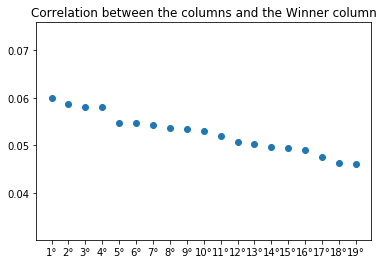

In [69]:
plt.title('Correlation between the columns and the Winner column')
plt.scatter(Fator_por_corr.index,Fator_por_corr.Correlação)

In [70]:
def relevancia(df,coluna_nome,coluna_correlacao,acuracia):
    inuteis = ['Winner']
    uteis = ['Winner']
    for index,row in df.iterrows():
        if row[coluna_correlacao] >= -acuracia and row[coluna_correlacao] <= acuracia:
            inuteis.append(row[coluna_nome])
        else:
            uteis.append(row[coluna_nome])
    return uteis

In [71]:
#def nome_e_vencedor(lista):
    #nova_lista = lista.append('R_fighter')
    #nova_lista = lista.append('B_fighter')
    #nova_lista = lista.append('Winner')
    #return nova_lista

In [72]:
uteis = relevancia(Fator_por_corr,'Fator','Correlação',0.01)

In [73]:
#tirando empates
data_heavy_util_relevante = data_heavy_util[data_heavy_util.Winner != 2]

In [74]:
data_heavy_util_relevante = data_heavy_util_relevante.loc[:,uteis]

In [75]:
data_heavy_util_relevante.head()

,Winner,R_avg_opp_LEG_att,R_avg_DISTANCE_landed,R_avg_opp_DISTANCE_landed,R_avg_DISTANCE_att,R_avg_opp_BODY_att,B_avg_opp_TOTAL_STR_landed,R_avg_opp_DISTANCE_att,R_avg_opp_TD_pct,R_avg_BODY_att,B_avg_SIG_STR_att,R_avg_opp_LEG_landed,B_avg_HEAD_att,R_avg_opp_SIG_STR_att,R_avg_opp_SIG_STR_landed,R_total_rounds_fought,R_age,B_avg_BODY_att,B_avg_opp_HEAD_landed,B_avg_opp_SUB_ATT
2,1,6.000000,49.466667,32.200000,116.133333,14.466667,49.774194,91.066667,0.131333,13.866667,97.000000,4.400000,67.645161,98.733333,35.733333,33,35.0,15.354839,25.483871,0.096774
16,0,4.000000,25.400000,22.600000,60.000000,7.400000,31.800000,84.400000,0.320000,9.000000,60.200000,3.800000,52.200000,95.000000,30.200000,12,32.0,7.000000,9.400000,0.800000
20,0,6.111111,29.888889,22.111111,74.888889,11.222222,47.000000,54.888889,0.203333,8.000000,62.333333,5.333333,46.666667,65.666667,29.222222,22,29.0,9.666667,15.166667,0.000000
21,0,7.142857,32.714286,36.285714,98.000000,13.142857,112.666667,101.285714,0.178571,10.428571,193.000000,5.571429,170.333333,105.142857,39.428571,19,35.0,21.666667,74.666667,0.333333
29,1,2.826087,12.000000,13.217391,29.434783,6.434783,59.863636,32.826087,0.244783,8.608696,87.227273,2.043478,66.136364,43.956522,20.260870,42,29.0,13.181818,27.772727,0.636364


In [76]:
data_heavy_util_relevante.Winner.value_counts()

1    416
0    220
Name: Winner, dtype: int64

### Random forest 2.0

In [77]:
data_heavy_num = data_heavy_util_relevante.astype('float')

In [78]:
X = data_heavy_num.drop('Winner', axis=1)
y = data_heavy_num['Winner']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [80]:
model = RandomForestClassifier(n_estimators=10000)

model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [81]:
y_pred = model.predict(X_test)

In [82]:
print(accuracy_score(y_test, y_pred))

0.6163522012578616


### Regressão Logística

In [41]:
def preparo(X,Y):
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp,missing='drop')
    results = model.fit()
    return results

In [42]:
Y_log = data_heavy_util_relevante["Winner"]
data_heavy_sem_Winner=data_heavy_util_relevante.drop('Winner',axis=1) 
X_log=data_heavy_sem_Winner
#np.asarray(X)

In [43]:
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, Y_log, test_size=0.25)

In [44]:
model = LogisticRegression(max_iter=200000,solver='lbfgs', multi_class='auto')

model.fit(X_train_log, y_train_log)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200000, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [45]:
y_pred_log = model.predict(X_test_log)

In [46]:
print(accuracy_score(y_test_log, y_pred_log))

0.6918238993710691


In [48]:
result = preparo(X_log,Y_log)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Winner   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     4.558
Date:                Thu, 21 Nov 2019   Prob (F-statistic):           7.94e-10
Time:                        14:29:52   Log-Likelihood:                -388.04
No. Observations:                 636   AIC:                             816.1
Df Residuals:                     616   BIC:                             905.2
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          1.4170      0.161      8.816      0.000       1.101       1.733
R_avg_opp_LEG_att             -0.0400      0.018     -2.206      0.028      -0.076      -0.004
R_avg_opp_DISTANCE_landed      0.0274      0.013      2.125      0.034       0.002       0.053
R_avg_opp_LEG_landed           0.0426      0.022      1.900      0.058      -0.001       0.087
R_avg_opp_DISTANCE_att        -0.0144      0.008     -1.708      0.088      -0.031       0.002
R_avg_DISTANCE_att            -0.0029      0.001     -2.016      0.044      -0.006   -7.47e-05
R_avg_opp_TD_pct              -0.0745      0.100     -0.747      0.455      -0.271       0.121
B_avg_SIG_STR_att              0.0022      0.004      0.575      0.565      -0.005       0.010
R_avg_opp_BODY_att             0.0030      0.006      0.489      0.625      -0.009       0.015
B_avg_BODY_att                -0.0072      0.006     -1.218      0.224      -0.019       0.004
R_avg_DISTANCE_landed          0.0046      0.004      1.185      0.236      -0.003       0.012
B_avg_HEAD_att                -0.0037      0.004     -0.928      0.354      -0.011       0.004
R_avg_opp_SIG_STR_landed      -0.0247      0.012     -2.001      0.046      -0.049      -0.000
R_total_rounds_fought         -0.0019      0.001     -1.317      0.188      -0.005       0.001
R_avg_opp_SIG_STR_att          0.0137      0.008      1.724      0.085      -0.002       0.029
R_avg_BODY_att                -0.0023      0.004     -0.507      0.612      -0.011       0.007
B_avg_opp_TOTAL_STR_landed     0.0035      0.001      2.660      0.008       0.001       0.006
R_age                         -0.0199      0.006     -3.492      0.001      -0.031      -0.009
B_avg_opp_HEAD_landed         -0.0040      0.003     -1.367      0.172      -0.010       0.002
B_avg_opp_SUB_ATT              0.0502      0.029      1.717      0.086      -0.007       0.108
==============================================================================
Omnibus:                      900.123   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.881
Skew:                          -0.490   Prob(JB):                     1.10e-15
Kurtosis:                       1.720   Cond. No.                     1.57e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [90]:
#criando um novo dataframe com apenas os lutadores sem repetição
def fighter_clean(data):
    newdata = pd.DataFrame()
    namelist = []

    for n in range(len(data.Fighter)):
        if data.loc[n,:]["Fighter"] not in namelist:
            namelist.append(data.loc[n,:]["Fighter"])
            newdata = pd.concat([newdata,data.loc[n,:]], axis=1, join='outer')

    newdata = newdata.transpose()
    return newdata


In [91]:
# Função que separa todos os atributos do red e blue
def colunas_RB(df):
    coluna_R = ['weight_class']
    coluna_B = ['weight_class']
    for e in df.columns:
        if e != 'Referee':
            for i in range(0,1):
                if e[i] == 'R':
                    coluna_R.append(e)
                elif e[i] == 'B':
                    coluna_B.append(e)
    return coluna_R,coluna_B

In [92]:
#criando um novo dataframe
lista_locB = colunas_RB(data)[1]
lista_locR = colunas_RB(data)[0]
data_red = data.loc[: , lista_locR]
data_blue = data.loc[: , lista_locB]

data_blue.columns = ['Weight Class','Fighter','Current Lose Streak','Current Win Streak','Draw','Avg BODY Att','Avg BODY Landed','Avg CLINCH Att','Avg CLINCH Landed','Avg DISTANCE Att','Avg DISTANCE Landed','Avg GROUND Att','Avg GROUND Landed','Avg HEAD Att','Avg HEAD Landed','Avg KD','Avg LEG Att','Avg LEG Landed','Avg PASS','Avg REV','Avg SIG STR Att', 'Avg SIG STR Landed', 'Avg SIG STR Pct', 'Avg SUB ATT', 'Avg TD Att', 'Avg TD Landed', 'Avg TD Pct', 'Avg TOTAL STR Att', 'Avg TOTAL STR Landed', 'Longest Win Streak', 'Losses', 'Avg_Opp BODY Att', 'Avg Opp BODY Landed', 'Avg Opp CLINCH Att', 'Avg Opp CLINCH Landed', 'Avg Opp DISTANCE Att', 'Avg Opp DISTANCE Landed', 'Avg Opp GROUND Att', 'Avg Opp GROUND Landed', 'Avg Opp HEAD Att', 'Avg Opp HEAD Landed', 'Avg Opp KD', 'Avg Opp LEG Att', 'Avg Opp LEG Landed', 'Avg Opp PASS', 'Avg Opp REV', 'Avg Opp SIG STR Att', 'Avg Opp SIG STR Landed', 'Avg Opp SIG STR Pct', 'Avg Opp SUB ATT', 'Avg Opp TD Att', 'Avg Opp TD Landed', 'Avg Opp TD Pct', 'Avg Opp TOTAL STR Att', 'Avg Opp TOTAL STR Landed', 'Total Rounds Fought', 'Total Time Fought(seconds)', 'Total Title Bouts', 'Win by Decision Majority', 'Win by Decision Split', 'Win by Decision Unanimous', 'Win by KO/TKO', 'Win by Submission', 'Win by TKO Doctor Stoppage', 'Wins', 'Stance', 'Height Cms', 'Reach Cms', 'Weight Lbs', 'Age']
data_red.columns = ['Weight Class','Fighter','Current Lose Streak','Current Win Streak','Draw','Avg BODY Att','Avg BODY Landed','Avg CLINCH Att','Avg CLINCH Landed','Avg DISTANCE Att','Avg DISTANCE Landed','Avg GROUND Att','Avg GROUND Landed','Avg HEAD Att','Avg HEAD Landed','Avg KD','Avg LEG Att','Avg LEG Landed','Avg PASS','Avg REV','Avg SIG STR Att', 'Avg SIG STR Landed', 'Avg SIG STR Pct', 'Avg SUB ATT', 'Avg TD Att', 'Avg TD Landed', 'Avg TD Pct', 'Avg TOTAL STR Att', 'Avg TOTAL STR Landed', 'Longest Win Streak', 'Losses', 'Avg_Opp BODY Att', 'Avg Opp BODY Landed', 'Avg Opp CLINCH Att', 'Avg Opp CLINCH Landed', 'Avg Opp DISTANCE Att', 'Avg Opp DISTANCE Landed', 'Avg Opp GROUND Att', 'Avg Opp GROUND Landed', 'Avg Opp HEAD Att', 'Avg Opp HEAD Landed', 'Avg Opp KD', 'Avg Opp LEG Att', 'Avg Opp LEG Landed', 'Avg Opp PASS', 'Avg Opp REV', 'Avg Opp SIG STR Att', 'Avg Opp SIG STR Landed', 'Avg Opp SIG STR Pct', 'Avg Opp SUB ATT', 'Avg Opp TD Att', 'Avg Opp TD Landed', 'Avg Opp TD Pct', 'Avg Opp TOTAL STR Att', 'Avg Opp TOTAL STR Landed', 'Total Rounds Fought', 'Total Time Fought(seconds)', 'Total Title Bouts', 'Win by Decision Majority', 'Win by Decision Split', 'Win by Decision Unanimous', 'Win by KO/TKO', 'Win by Submission', 'Win by TKO Doctor Stoppage', 'Wins', 'Stance', 'Height Cms', 'Reach Cms', 'Weight Lbs', 'Age']

data_blue = fighter_clean(data_blue)
data_red = fighter_clean(data_red)

dataRB = pd.concat([data_red,data_blue], axis=0, join='outer')

dataRB.reset_index(inplace=True)
dataRB = fighter_clean(dataRB).loc[: , ['Weight Class','Fighter','Current Lose Streak','Current Win Streak','Draw','Avg BODY Att','Avg BODY Landed','Avg CLINCH Att','Avg CLINCH Landed','Avg DISTANCE Att','Avg DISTANCE Landed','Avg GROUND Att','Avg GROUND Landed','Avg HEAD Att','Avg HEAD Landed','Avg KD','Avg LEG Att','Avg LEG Landed','Avg PASS','Avg REV','Avg SIG STR Att', 'Avg SIG STR Landed', 'Avg SIG STR Pct', 'Avg SUB ATT', 'Avg TD Att', 'Avg TD Landed', 'Avg TD Pct', 'Avg TOTAL STR Att', 'Avg TOTAL STR Landed', 'Longest Win Streak', 'Losses', 'Avg_Opp BODY Att', 'Avg Opp BODY Landed', 'Avg Opp CLINCH Att', 'Avg Opp CLINCH Landed', 'Avg Opp DISTANCE Att', 'Avg Opp DISTANCE Landed', 'Avg Opp GROUND Att', 'Avg Opp GROUND Landed', 'Avg Opp HEAD Att', 'Avg Opp HEAD Landed', 'Avg Opp KD', 'Avg Opp LEG Att', 'Avg Opp LEG Landed', 'Avg Opp PASS', 'Avg Opp REV', 'Avg Opp SIG STR Att', 'Avg Opp SIG STR Landed', 'Avg Opp SIG STR Pct', 'Avg Opp SUB ATT', 'Avg Opp TD Att', 'Avg Opp TD Landed', 'Avg Opp TD Pct', 'Avg Opp TOTAL STR Att', 'Avg Opp TOTAL STR Landed', 'Total Rounds Fought', 'Total Time Fought(seconds)', 'Total Title Bouts', 'Win by Decision Majority', 'Win by Decision Split', 'Win by Decision Unanimous', 'Win by KO/TKO', 'Win by Submission', 'Win by TKO Doctor Stoppage', 'Wins', 'Stance', 'Height Cms', 'Reach Cms', 'Weight Lbs', 'Age']]

dataRB = dataRB.set_index("Fighter")

dataRB = dataRB.dropna()

dataRB.head(3)

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


,Weight Class,Current Lose Streak,Current Win Streak,Draw,Avg BODY Att,Avg BODY Landed,Avg CLINCH Att,Avg CLINCH Landed,Avg DISTANCE Att,Avg DISTANCE Landed,...,Win by Decision Unanimous,Win by KO/TKO,Win by Submission,Win by TKO Doctor Stoppage,Wins,Stance,Height Cms,Reach Cms,Weight Lbs,Age
Fighter,,,,,,,,,,,,,,,,,,,,,
Henry Cejudo,Bantamweight,0,4,0,21.9,16.4,17,11,75,26.5,...,4,2,0,0,8,Orthodox,162.56,162.56,135,32
Valentina Shevchenko,Women's Flyweight,0,2,0,12,7.71429,9.28571,6.85714,88.1429,36.1429,...,2,0,2,0,5,Southpaw,165.1,167.64,125,31
Tony Ferguson,Lightweight,0,11,0,13.8667,8.66667,2.86667,1.73333,116.133,49.4667,...,3,3,6,1,14,Orthodox,180.34,193.04,155,35


In [93]:
colunas_RB(data)[1]

['weight_class',
 'B_fighter',
 'B_current_lose_streak',
 'B_current_win_streak',
 'B_draw',
 'B_avg_BODY_att',
 'B_avg_BODY_landed',
 'B_avg_CLINCH_att',
 'B_avg_CLINCH_landed',
 'B_avg_DISTANCE_att',
 'B_avg_DISTANCE_landed',
 'B_avg_GROUND_att',
 'B_avg_GROUND_landed',
 'B_avg_HEAD_att',
 'B_avg_HEAD_landed',
 'B_avg_KD',
 'B_avg_LEG_att',
 'B_avg_LEG_landed',
 'B_avg_PASS',
 'B_avg_REV',
 'B_avg_SIG_STR_att',
 'B_avg_SIG_STR_landed',
 'B_avg_SIG_STR_pct',
 'B_avg_SUB_ATT',
 'B_avg_TD_att',
 'B_avg_TD_landed',
 'B_avg_TD_pct',
 'B_avg_TOTAL_STR_att',
 'B_avg_TOTAL_STR_landed',
 'B_longest_win_streak',
 'B_losses',
 'B_avg_opp_BODY_att',
 'B_avg_opp_BODY_landed',
 'B_avg_opp_CLINCH_att',
 'B_avg_opp_CLINCH_landed',
 'B_avg_opp_DISTANCE_att',
 'B_avg_opp_DISTANCE_landed',
 'B_avg_opp_GROUND_att',
 'B_avg_opp_GROUND_landed',
 'B_avg_opp_HEAD_att',
 'B_avg_opp_HEAD_landed',
 'B_avg_opp_KD',
 'B_avg_opp_LEG_att',
 'B_avg_opp_LEG_landed',
 'B_avg_opp_PASS',
 'B_avg_opp_REV',
 'B_avg_opp_S

In [95]:
p3 = ['edgard','victor','maulem','yama']
p3.pop(2)
p3

['edgard', 'victor', 'yama']